# Section4：畳み込みニューラルネットワークの概念

畳み込みニューラルネットワークは画像に関するニューラルネットワークで使用されるが、次元的なデータであれば何でも処理できる。

|  |１次元 | ２次元 | ３次元 |
| :--- | :---: | :---: | :---: |
| 単一チャンネル | 音声<br> [時刻、強度] | フーリエ変換した音声<br> [時刻、周波数、強度] | CTスキャン画像<br> [時x、y、z、強度] |
| 複数チャンネル | アニメのスケルトン <br> [時刻、（腕の値、膝の値）] | カラー画像<br> [x、y、（R,G,B）] | 動画<br> [時刻、（R,G,B）] |


### CCNの構造図（例）

- 入力層
- 畳み込み層（Convolutions）
- プーリング層（Subsampling）
- 全結合層（Full connection）
- 出力層

### LeNetの構造図

1. 入力層　　　：32×32の画像（1,024個）
1. 畳み込み層　：28×28×6（4,704個）
1. プーリング層：14×14×6（1,176個）
1. 畳み込み層　：10×10×16（1,600個）
1. プーリング層：5×5×16（400個）
1. 全結合層　　：120個
1. 全結合層　　：84個
1. 出力層　　　：10個の分類結果

## 4-1 畳み込み層

#### 畳み込み層の全体像


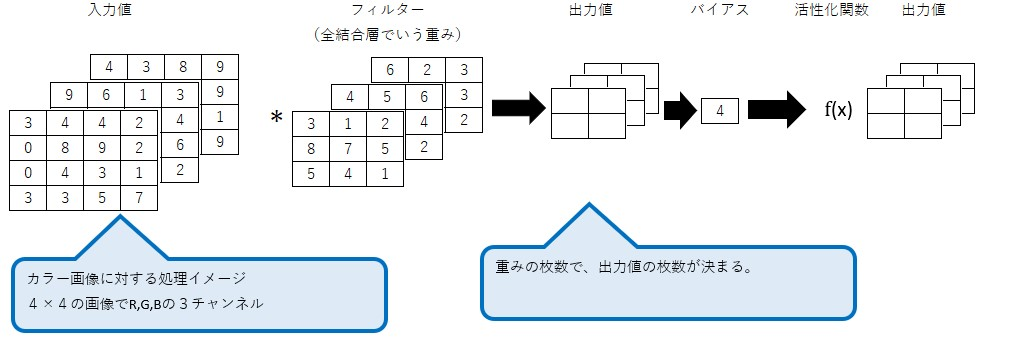

In [1]:
from IPython.display import Image
Image("./Section4_01_CNN全体像.jpg")

計算の全体像は以下のイメージ（正しく計算していないため、出力値の値はあくまでも概念）

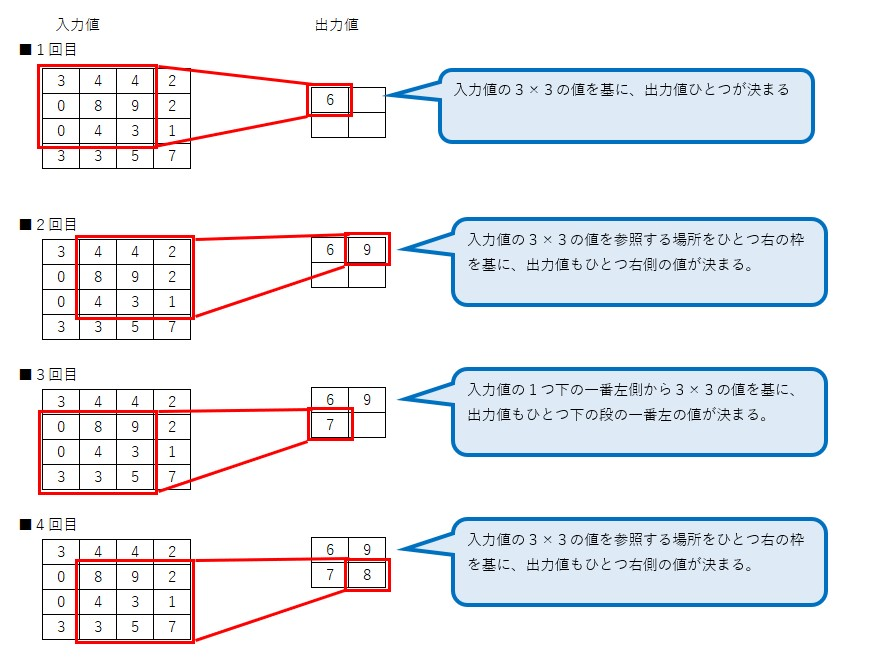

In [5]:
Image("./Section4_02_出力値が決まるまでの処理イメージ.jpg")

### 4-1-1 バイアス
畳み込み層では、画像の場合、縦、横、チャンネルの3次元のデータをそのまま学習し、次に伝えることができる。

結論:3次元の空間情報も学習できるような層が畳み込み層である。

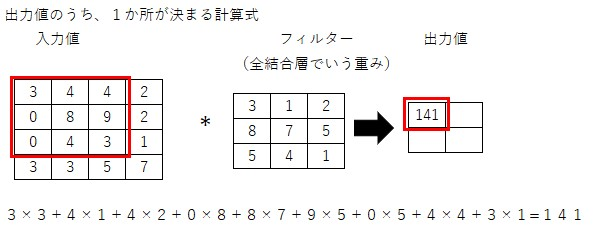

In [11]:
Image("./Section4_03_計算.jpg")

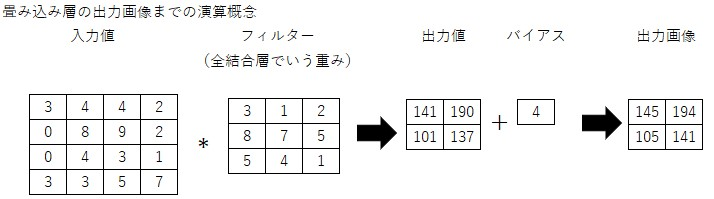

In [12]:
Image("./Section4_04_畳み込み層の演算概念.jpg")

### 4-1-2 パディング

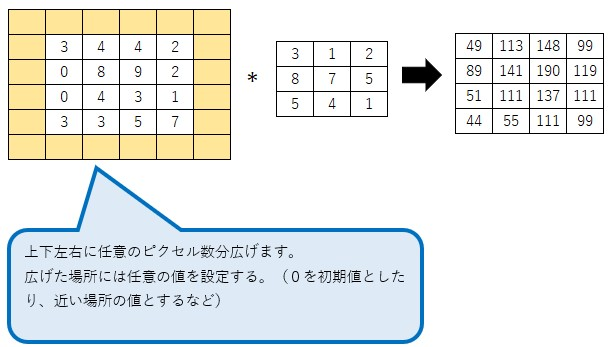

In [3]:
Image("./Section4_05_パディング.jpg")

### 4-1-3 ストライド

画像を読み込んだ際に横に動くピクセルの数を指定する。

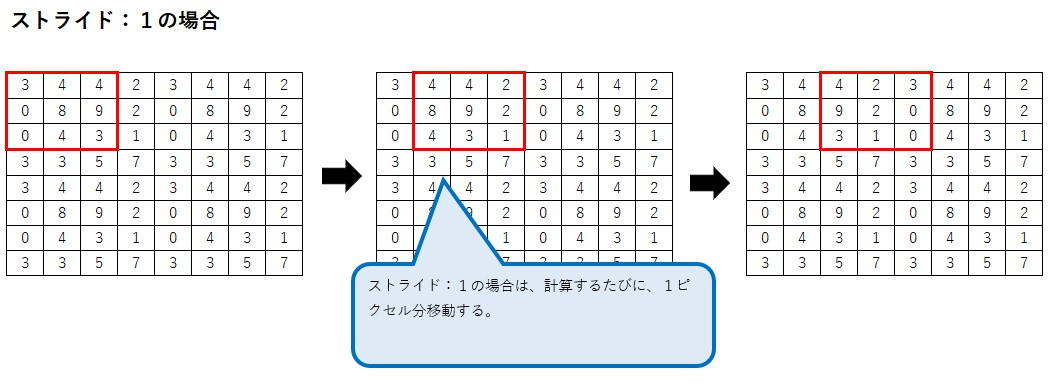

In [4]:
Image("./Section4_06_ストライド１.jpg")

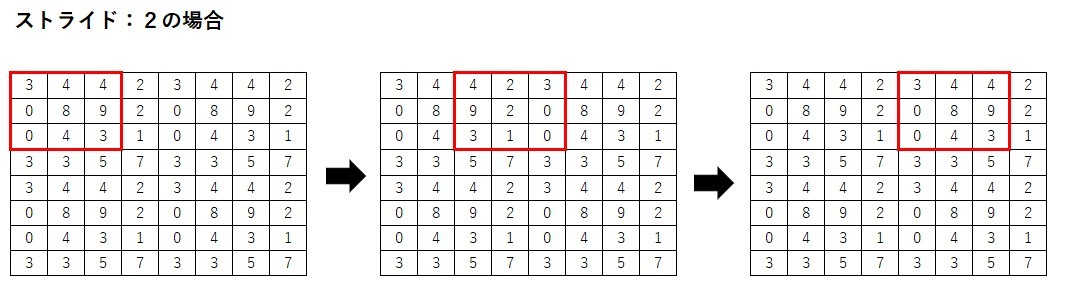

In [5]:
Image("./Section4_07_ストライド２.jpg")

### 4-1-4 チャンネル

フィルターの数

### 全結合層で画像を学習した際の課題

全結合層のデメリット
- 画像の場合、縦、横、チャンネルの３次元データだが、１次元のデータとして処理される。
　⇒RGBの各チャンネル間の関連性が学習に反映されないということ。
 
このデメリットを解消するために、畳み込み演算が追加された。

## 実装演習

# simple convolution network

## image to column

In [20]:
import pickle
import numpy as np
from collections import OrderedDict
from common import layers
from common import optimizer
from data.mnist import load_mnist
import matplotlib.pyplot as plt

# 画像データを２次元配列に変換
'''
input_data: 入力値
filter_h: フィルターの高さ
filter_w: フィルターの横幅
stride: ストライド
pad: パディング
'''
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    # N: number, C: channel, H: height, W: width
    N, C, H, W = input_data.shape
    out_h = (H + 2 * pad - filter_h)//stride + 1
    out_w = (W + 2 * pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride * out_h
        for x in range(filter_w):
            x_max = x + stride * out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]
    
    # col = col.transpose(0, 4, 5, 1, 2, 3) # (N, C, filter_h, filter_w, out_h, out_w) -> (N, filter_w, out_h, out_w, C, filter_h)    
    
    col = col.reshape(N * out_h * out_w, -1)
    return col

## [try] im2colの処理を確認しよう
- 関数内でtransposeの処理をしている行をコメントアウトして下のコードを実行してみよう

In [21]:
# im2colの処理確認
input_data = np.random.rand(2, 1, 4, 4)*100//1 # number, channel, height, widthを表す
print('========== input_data ===========\n', input_data)
print('==============================')
filter_h = 3
filter_w = 3
stride = 1
pad = 0
col = im2col(input_data, filter_h=filter_h, filter_w=filter_w, stride=stride, pad=pad)
print('============= col ==============\n', col)
print('==============================')

========== input_data ===========
 [[[[95. 99. 27. 57.]
   [16. 17.  5. 52.]
   [80. 11. 25. 88.]
   [37. 24.  3. 59.]]]


 [[[67. 74. 82. 29.]
   [ 3. 56. 67. 46.]
   [84. 66. 20. 80.]
   [72. 57. 25. 82.]]]]
============= col ==============
 [[95. 99. 16. 17. 99. 27. 17.  5. 27.]
 [57.  5. 52. 16. 17. 80. 11. 17.  5.]
 [11. 25.  5. 52. 25. 88. 80. 11. 37.]
 [24. 11. 25. 24.  3. 25. 88.  3. 59.]
 [67. 74.  3. 56. 74. 82. 56. 67. 82.]
 [29. 67. 46.  3. 56. 84. 66. 56. 67.]
 [66. 20. 67. 46. 20. 80. 84. 66. 72.]
 [57. 66. 20. 57. 25. 20. 80. 25. 82.]]


In [22]:
# 画像データを２次元配列に変換
'''
input_data: 入力値
filter_h: フィルターの高さ
filter_w: フィルターの横幅
stride: ストライド
pad: パディング
'''
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    # N: number, C: channel, H: height, W: width
    N, C, H, W = input_data.shape
    out_h = (H + 2 * pad - filter_h)//stride + 1
    out_w = (W + 2 * pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride * out_h
        for x in range(filter_w):
            x_max = x + stride * out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]
    
    col = col.transpose(0, 4, 5, 1, 2, 3) # (N, C, filter_h, filter_w, out_h, out_w) -> (N, filter_w, out_h, out_w, C, filter_h)    
    
    col = col.reshape(N * out_h * out_w, -1)
    return col

In [23]:
# im2colの処理確認
input_data = np.random.rand(2, 1, 4, 4)*100//1 # number, channel, height, widthを表す
print('========== input_data ===========\n', input_data)
print('==============================')
filter_h = 3
filter_w = 3
stride = 1
pad = 0
col = im2col(input_data, filter_h=filter_h, filter_w=filter_w, stride=stride, pad=pad)
print('============= col ==============\n', col)
print('==============================')

========== input_data ===========
 [[[[88. 48. 80. 55.]
   [ 7. 12. 21. 44.]
   [16. 64. 46. 85.]
   [30. 44. 34.  8.]]]


 [[[68. 32.  2. 46.]
   [93. 68. 84. 19.]
   [19. 41. 45. 56.]
   [82. 46. 92. 68.]]]]
============= col ==============
 [[88. 48. 80.  7. 12. 21. 16. 64. 46.]
 [48. 80. 55. 12. 21. 44. 64. 46. 85.]
 [ 7. 12. 21. 16. 64. 46. 30. 44. 34.]
 [12. 21. 44. 64. 46. 85. 44. 34.  8.]
 [68. 32.  2. 93. 68. 84. 19. 41. 45.]
 [32.  2. 46. 68. 84. 19. 41. 45. 56.]
 [93. 68. 84. 19. 41. 45. 82. 46. 92.]
 [68. 84. 19. 41. 45. 56. 46. 92. 68.]]


In [8]:
# ２次元配列を画像データに変換
def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    # N: number, C: channel, H: height, W: width
    N, C, H, W = input_shape
    # 切り捨て除算    
    out_h = (H + 2 * pad - filter_h)//stride + 1
    out_w = (W + 2 * pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2) # (N, filter_h, filter_w, out_h, out_w, C)

    img = np.zeros((N, C, H + 2 * pad + stride - 1, W + 2 * pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride * out_h
        for x in range(filter_w):
            x_max = x + stride * out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

In [15]:
out = col2im(col=col , input_shape=input_data.shape  ,filter_h=filter_h, filter_w=filter_w, stride=stride, pad=pad)
print(out)

[[[[ 79. 144.  12.  27.]
   [172.  32.  40.  52.]
   [164. 396. 348.  44.]
   [ 20. 130. 192.  37.]]]


 [[[ 70.  62.  64.  31.]
   [ 76.  48.  48.  32.]
   [  0. 184. 180. 110.]
   [ 82. 160. 112.   6.]]]]


## [try] im2colの処理を確認しよう
- input_dataの各次元のサイズやフィルターサイズ・ストライド・パディングを変えてみよう

In [16]:
# im2colの処理確認
input_data = np.random.rand(3, 1, 10, 9)*100//1 # number, channel, height, widthを表す
print('========== input_data ===========\n', input_data)
print('==============================')
filter_h = 3
filter_w = 3
stride = 1
pad = 0
col = im2col(input_data, filter_h=filter_h, filter_w=filter_w, stride=stride, pad=pad)
print('============= col ==============\n', col)
print('==============================')

========== input_data ===========
 [[[[37. 15. 43. 79. 70. 67. 88.  0. 11.]
   [46. 50. 87. 11. 48. 92.  3. 98. 89.]
   [79. 74.  5. 33. 51. 76. 34.  2. 70.]
   [26. 21. 70. 30. 67. 95. 80. 83. 19.]
   [ 3. 75. 14. 57. 16. 66.  5. 59. 80.]
   [62. 99. 10. 88. 34. 72. 97. 75. 92.]
   [28.  8. 88. 25. 18. 28.  3. 29. 54.]
   [66. 29. 18. 98. 30. 83. 40. 44. 27.]
   [20. 64. 15. 60. 72. 21. 86. 12. 46.]
   [27. 70. 93. 81. 85. 67. 25. 41. 73.]]]


 [[[19. 57. 16. 22. 47.  4. 63. 48. 65.]
   [47. 37. 54.  7. 44. 41. 56. 70. 84.]
   [51. 20. 25. 74. 41. 11. 51. 51. 43.]
   [30. 98. 82. 99. 29. 97. 36. 29. 81.]
   [61. 16. 89. 41. 44. 88. 55. 23. 87.]
   [ 4.  3. 56. 61. 98. 36.  7. 39. 68.]
   [69. 79. 77. 47. 61. 76. 61.  2. 66.]
   [13. 52. 58. 27. 58. 74.  9. 81. 13.]
   [72. 43. 48. 95. 94. 21. 92. 20. 16.]
   [80. 46. 62. 14. 55. 71. 13. 13. 57.]]]


 [[[79. 34.  0. 28. 94. 67.  4. 41. 90.]
   [97. 97. 84. 71. 38. 34. 58. 48. 84.]
   [38. 20. 48. 23. 51. 57. 72. 20. 26.]
   [18. 55. 21

In [17]:
out = col2im(col=col , input_shape=input_data.shape  ,filter_h=filter_h, filter_w=filter_w, stride=stride, pad=pad)
print(out)

[[[[ 37.  30. 129. 237. 210. 201. 264.   0.  11.]
   [ 92. 200. 522.  66. 288. 552.  18. 392. 178.]
   [237. 444.  45. 297. 459. 684. 306.  12. 210.]
   [ 78. 126. 630. 270. 603. 855. 720. 498.  57.]
   [  9. 450. 126. 513. 144. 594.  45. 354. 240.]
   [186. 594.  90. 792. 306. 648. 873. 450. 276.]
   [ 84.  48. 792. 225. 162. 252.  27. 174. 162.]
   [198. 174. 162. 882. 270. 747. 360. 264.  81.]
   [ 40. 256.  90. 360. 432. 126. 516.  48.  92.]
   [ 27. 140. 279. 243. 255. 201.  75.  82.  73.]]]


 [[[ 19. 114.  48.  66. 141.  12. 189.  96.  65.]
   [ 94. 148. 324.  42. 264. 246. 336. 280. 168.]
   [153. 120. 225. 666. 369.  99. 459. 306. 129.]
   [ 90. 588. 738. 891. 261. 873. 324. 174. 243.]
   [183.  96. 801. 369. 396. 792. 495. 138. 261.]
   [ 12.  18. 504. 549. 882. 324.  63. 234. 204.]
   [207. 474. 693. 423. 549. 684. 549.  12. 198.]
   [ 39. 312. 522. 243. 522. 666.  81. 486.  39.]
   [144. 172. 288. 570. 564. 126. 552.  80.  32.]
   [ 80.  92. 186.  42. 165. 213.  39.  26.  5

## convolution class　畳み込み層

In [24]:
class Convolution:
    # W: フィルター, b: バイアス
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        # 中間データ（backward時に使用）
        self.x = None   
        self.col = None
        self.col_W = None
        
        # フィルター・バイアスパラメータの勾配
        self.dW = None
        self.db = None

    def forward(self, x):
        # FN: filter_number, C: channel, FH: filter_height, FW: filter_width
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        # 出力値のheight, width
        out_h = 1 + int((H + 2 * self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2 * self.pad - FW) / self.stride)
        
        # xを行列に変換
        col = im2col(x, FH, FW, self.stride, self.pad)
        # フィルターをxに合わせた行列に変換
        col_W = self.W.reshape(FN, -1).T

        out = np.dot(col, col_W) + self.b
        # 計算のために変えた形式を戻す
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0, 2, 3, 1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        # dcolを画像データに変換
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx


## pooling class プーリング層

In [25]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        
        # xを行列に変換
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        # プーリングのサイズに合わせてリサイズ
        col = col.reshape(-1, self.pool_h*self.pool_w)
        
        # 行ごとに最大値を求める
        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        # 整形
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx


## simple convolution network class

In [26]:
class SimpleConvNet:
    # conv - relu - pool - affine - relu - affine - softmax
    def __init__(self, input_dim=(1, 28, 28), conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']        
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2 * filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size / 2) * (conv_output_size / 2))

        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Conv1'] = layers.Convolution(self.params['W1'], self.params['b1'], conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = layers.Relu()
        self.layers['Pool1'] = layers.Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = layers.Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = layers.Relu()
        self.layers['Affine2'] = layers.Affine(self.params['W3'], self.params['b3'])

        self.last_layer = layers.SoftmaxWithLoss()

    def predict(self, x):
        for key in self.layers.keys():
            x = self.layers[key].forward(x)
        return x
        
    def loss(self, x, d):
        y = self.predict(x)
        return self.last_layer.forward(y, d)

    def accuracy(self, x, d, batch_size=100):
        if d.ndim != 1 : d = np.argmax(d, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            td = d[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == td) 
        
        return acc / x.shape[0]

    def gradient(self, x, d):
        # forward
        self.loss(x, d)
        
        # backward
        dout = 1
        dout = self.last_layer.backward(dout)
        layers = list(self.layers.values())
        
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grad = {}
        grad['W1'], grad['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grad['W2'], grad['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grad['W3'], grad['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grad

データ読み込み完了
Generation: 200. 正答率(トレーニング) = 0.9292
                : 200. 正答率(テスト) = 0.898
Generation: 400. 正答率(トレーニング) = 0.9636
                : 400. 正答率(テスト) = 0.93
Generation: 600. 正答率(トレーニング) = 0.9808
                : 600. 正答率(テスト) = 0.945
Generation: 800. 正答率(トレーニング) = 0.9872
                : 800. 正答率(テスト) = 0.952
Generation: 1000. 正答率(トレーニング) = 0.9966
                : 1000. 正答率(テスト) = 0.959


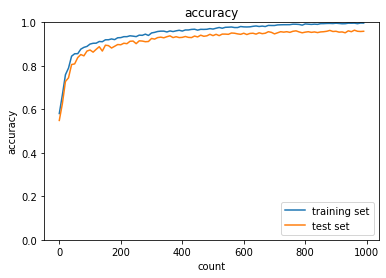

In [27]:
from common import optimizer

# データの読み込み
(x_train, d_train), (x_test, d_test) = load_mnist(flatten=False)

print("データ読み込み完了")

# 処理に時間のかかる場合はデータを削減 
x_train, d_train = x_train[:5000], d_train[:5000]
x_test, d_test = x_test[:1000], d_test[:1000]


network = SimpleConvNet(input_dim=(1,28,28), conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)

optimizer = optimizer.Adam()

iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10



for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]
    
    grad = network.gradient(x_batch, d_batch)
    optimizer.update(network.params, grad)

    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)

    if (i+1) % plot_interval == 0:
        accr_train = network.accuracy(x_train, d_train)
        accr_test = network.accuracy(x_test, d_test)
        accuracies_train.append(accr_train)
        accuracies_test.append(accr_test)
        
        if (i+1) % 200 == 0:
            print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
            print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))               

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

## 4-2 プーリング層

#### 畳み込み層の入出力画像
- 出力画像の高さ：(入力画像の高さ + 2 x パディング数　- フィルターの高さ) / ストライド ) + 1
- 出力画像の幅　：(入力画像の幅 + 2 x パディング数　- フィルターの幅) / ストライド ) + 1

#### ゼロから作るディープラーニング　7章　畳み込みニューラルネットワーク
#### ゼロから作るディープラーニング　7.1　全体の構造
#### ゼロから作るディープラーニング　7.2　畳み込み層
#### ゼロから作るディープラーニング　7.2.1　全結合層の問題点
#### ゼロから作るディープラーニング　7.2.2　畳み込み演算
#### ゼロから作るディープラーニング　7.2.3　パディング
#### ゼロから作るディープラーニング　7.2.4　ストライド
#### ゼロから作るディープラーニング　7.3　プーリング層

■■■■■

# 確認テスト

問） \
サイズ6×6の入力画像を、サイズ2×2のフィルタで畳み込んだ時の出力画像のサイズを答えよ。 \
なおストライドとパディングは1とする。